In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numba
%matplotlib inline
plt.style.use('ggplot')

In [20]:
geom_df = pd.read_excel('./Laplace_geom.xlsx', index_col=0, dtype=np.int64, engine='openpyxl')

In [21]:
num_x, num_y = geom_df.shape

In [22]:
geom_df.shape

(100, 100)

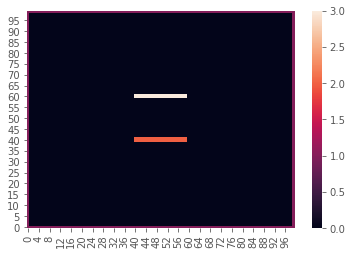

In [23]:
sns.heatmap(geom_df).invert_yaxis()

In [43]:
class Poisson(object):
    def __init__(self, geom, threshold, n_max):
        self.nx, self.ny = geom.shape
        self.geom = geom.values
        self.thresh = threshold
        self.n_max =n_max
        self.volt = np.zeros([self.nx, self.ny])
        self.omega = 1.5
        
    @staticmethod
    @numba.jit(nopython=True)
    def solver(nx, ny, arr, geom, omega):
        for y in range(ny):
            for x in range(nx):
                if geom[x, y] == 0:
                    arr[x, y] = arr[x, y] + omega * ((arr[x+1, y] + arr[x-1,y] + arr[x, y+1] + arr[x, y-1]) / 4.0 - arr[x, y])
                elif geom[x, y] == 1:
                    arr[x, y] = 0
                elif geom[x, y] == 2:
                    arr[x, y] = -1.0
                elif geom[x, y] == 3:
                    arr[x, y] = 1.0
        return arr
    
    def run(self):
        volt_old = np.copy(self.volt)
        for i in range(self.n_max):
            self.volt = self.solver(self.nx, self.ny, self.volt, self.geom, self.omega)
            err = np.sum(np.abs(self.volt - volt_old))
            if err < self.thresh:
                break
            if i % 100 ==0:
                print('step: {}, residual: {}'.format(i, err))
            volt_old = np.copy(self.volt)

In [44]:
poisson = Poisson(geom_df, 1e-5, 5000)

In [45]:
poisson.run()

step: 0, residual: 145.99551699050372
step: 100, residual: 4.663317308916571
step: 200, residual: 1.8697276089780233
step: 300, residual: 0.72642377323666
step: 400, residual: 0.27994631495916206
step: 500, residual: 0.1077003519034112
step: 600, residual: 0.041468165217295454
step: 700, residual: 0.01599838724808584
step: 800, residual: 0.00619269883684876
step: 900, residual: 0.0024081503462074225
step: 1000, residual: 0.0009422254387606466
step: 1100, residual: 0.00037176055042695917
step: 1200, residual: 0.00014830581677574513
step: 1300, residual: 6.0030673622194517e-05
step: 1400, residual: 2.4770161125037027e-05
step: 1500, residual: 1.0490489142038007e-05


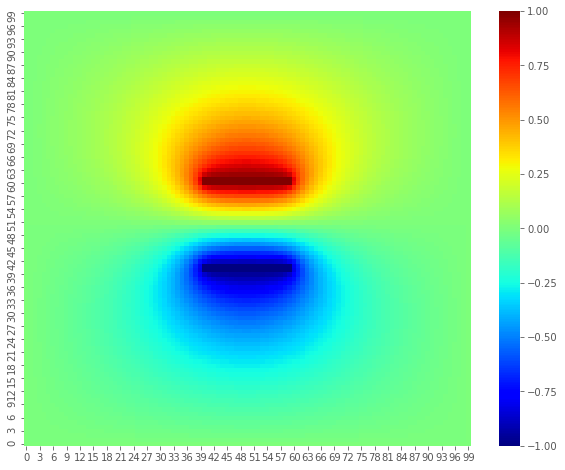

In [46]:
plt.figure(figsize=(10,8))
sns.heatmap(poisson.volt, cmap='jet').invert_yaxis()

In [47]:
Ex, Ey = np.gradient(poisson.volt)

In [48]:
Ex *= -1
Ey *= -1

In [49]:
norm_const = np.hypot(Ex,Ey)

In [50]:
np.sum(np.where(norm_const == 0, 1, 0))

4

In [51]:
norm_const_mean = np.mean(norm_const)

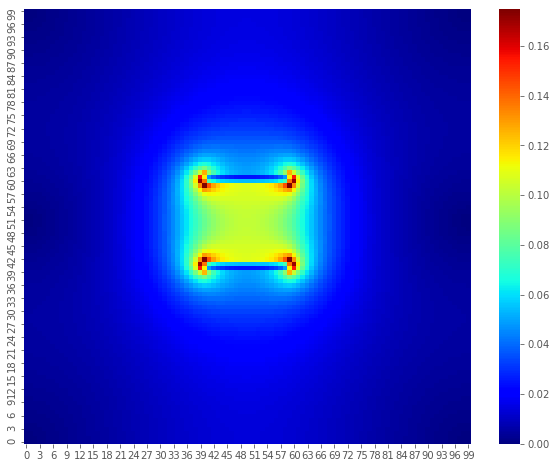

In [52]:
plt.figure(figsize=(10,8))
sns.heatmap(norm_const, cmap='jet').invert_yaxis()

In [53]:
Ex /= norm_const
Ey /= norm_const

/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


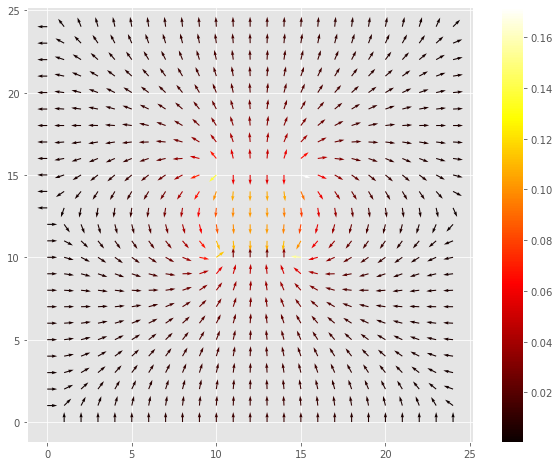

In [54]:
plt.figure(figsize=(10, 8))
plt.quiver(Ey[::4, ::4],Ex[::4, ::4], norm_const[::4, ::4], cmap='hot')
plt.colorbar()